# Cohort Analysis

In this section, review count will be used as metric to evaluate the customer cohort

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

## Load data

In [3]:
conn = sqlite3.connect('yelp_dataset_reviews.db') 
df_reviews= pd.read_sql("""SELECT * FROM reviews""",conn )
conn.close()

In [107]:
conn = sqlite3.connect('yelp_dataset_business.db') 
df_business= pd.read_sql("""SELECT business_id,name,stars,review_count,is_open
                        FROM business""",
                        conn )
conn.close()

## Calculate percentage of retain(total reviews/yelp usage)

In [145]:
def get_pct_retain(df_reviews):
    first_entry = df_reviews.groupby('business_id')['date'].min().reset_index()
    first_entry.rename(columns={'date': 'first_entry'}, inplace=True)
    merged_data = pd.merge(df_reviews, first_entry, on='business_id')
    merged_data['period'] = merged_data['date'].dt.year - merged_data['first_entry'].dt.year
    result = merged_data.groupby('period')['business_id'].nunique().reset_index(name='cohort_retained')
    result = result.sort_values('period')
    result['cohort_size'] = result['cohort_retained'].max()
    result["pct_retained"] = result['cohort_retained']/result["cohort_size"]
    return result


In [146]:
result = get_pct_retain(df_reviews)

### make a plot

Text(0, 0.5, 'pct_retained')

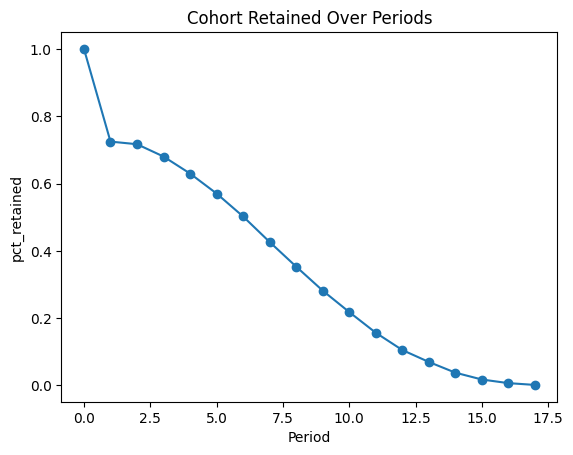

In [147]:
plt.plot(result['period'], result['pct_retained'], marker='o')
plt.title('Cohort Retained Over Periods')
plt.xlabel('Period')
plt.ylabel('pct_retained')

There is a particularly sharp drop in the retention percentage between the first and second periods. After the initial sharp drop, the decline in retention becomes more gradual, indicating a steady rate of decrease in the proportion of retained reviews as time goes on. Despite the decrease, the plot shows that there is still a significant percentage of reviews retained even in later periods. 

## Calculate percentage of retain(for each business)

In [148]:
df_reviews['date'] = pd.to_datetime(df_reviews['date'])
df_merge = pd.merge(df_reviews,df_business, on='business_id')
first_entry = df_reviews.groupby('business_id')['date'].min().reset_index()
first_entry.rename(columns={'date': 'first_entry'}, inplace=True)

In [93]:

# Merge this information back into the original DataFrame
merged_reviews = df_reviews.merge(first_entry, on='business_id')

# Calculate the period (e.g., in years) for each review
merged_reviews['period'] = merged_reviews['date'].dt.to_period('Y').astype(int) - merged_reviews['first_entry'].dt.to_period('Y').astype(int)

first_period_reviews = merged_reviews[merged_reviews['period'] == 0]

# Count the number of reviews for each business_id in the first period
initial_counts = first_period_reviews.groupby('business_id').size()


# For each period, count the number of retained reviews for each business_id
retained_counts = merged_reviews.groupby(['business_id', 'period']).size()

# Calculate pct_retained for each business_id and period
# This will be a Series with a MultiIndex of (business_id, period)
pct_retained = retained_counts.div(initial_counts, level='business_id')

# Reset the index if you want a DataFrame
pct_retained = pct_retained.reset_index(name='pct_retained')

In [ ]:
df_business.groupby("review_count").size()[:50].plot(kind='bar')

## Calculate percentage retained for closed business and open business

In [149]:
open_businesses = df_merge[df_merge.is_open==1]
open_pct = get_pct_retain(open_businesses)

In [151]:
close_businesses = df_merge[df_merge.is_open==0]
close_pct = get_pct_retain(close_businesses)

### plot and compare

Text(0, 0.5, 'Pct_retained')

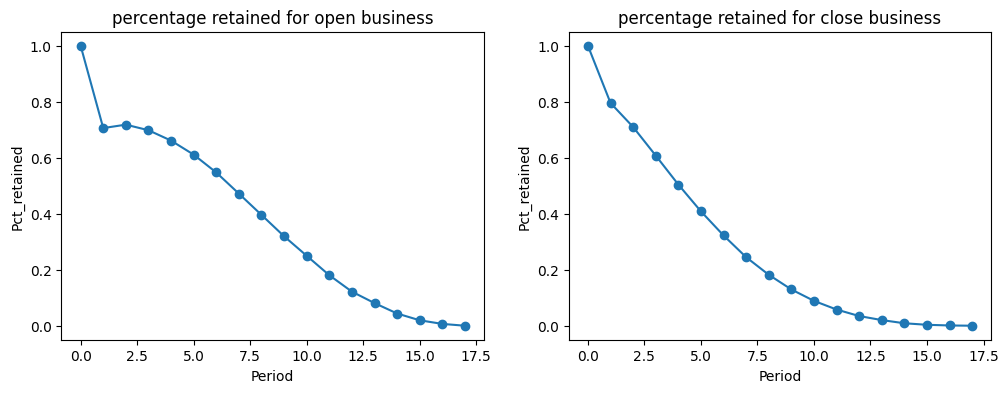

In [158]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# Plot on the first subplot
ax1.plot(open_pct['period'], open_pct['pct_retained'], marker='o')
ax1.set_title('percentage retained for open business')
ax1.set_xlabel('Period')
ax1.set_ylabel('Pct_retained')

# Plot on the second subplot
ax2.plot(close_pct['period'], close_pct['pct_retained'], marker='o')
ax2.set_title('percentage retained for close business')
ax2.set_xlabel('Period')
ax2.set_ylabel('Pct_retained')


The plots above reveal a pronounced drop in the retention of reviews after the initial period for both open and closed businesses. Notably, the falloff is more acute for businesses that have closed, with the most significant drops occurring in the early stages. In contrast, the trend for open businesses includes periods where the retention rate actually increases, suggesting a growth in customer reviews. This pattern may reflect customer engagement and the business's ability to retain and attract new patrons. The retention rate of reviews could therefore be an indicator of customer behavior and business health, where sustained or increasing review retention might correlate with a higher likelihood of the business remaining open.